## VAFC with Precise Learner and Horseshoe Prior
Author: Clara Hoffmann
    
This code computes the VAFC to obtain marginally calibrared posterior densities
for the response. Increasing the number of reparameterization samples $v$ can lead
to faster convergence but makes each iteration slower.

Overview:
1. Initialize Variables
2. Run VAFC
3. Plot ELBO

Note that the evaluation of the gradients and lower bounds is already parallelized, but
still increasing $v$ slows the code down. Overall, this only makes a small difference in runtime since
we achieve faster convergence with higher $v$. But the gains from increasing $v$ do not
grow linearly.

Based on 'Gaussian variational approximation with a factor covariance structure' by Ong et. al (2017)

In [1]:
import numpy as np
import helpers_horseshoe as hlp
import math
from random import random, seed
from numpy.linalg import multi_dot
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt 
from tqdm import tqdm
import ray
import time
ray.init()

2021-07-27 20:04:09,736	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.140.16',
 'raylet_ip_address': '192.168.140.16',
 'redis_address': '192.168.140.16:6379',
 'object_store_address': '/tmp/ray/session_2021-07-27_20-04-09_191377_46723/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-07-27_20-04-09_191377_46723/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-07-27_20-04-09_191377_46723',
 'metrics_export_port': 57312,
 'node_id': 'c8e3d215c299896c2fd01a7e48ab2ccc56744e16b36feebf8eb6103a'}

In [2]:
extracted_coefficients_path = '../../data/commaai/extracted_coefficients/copula_cpl/'
B_zeta_path = str(extracted_coefficients_path + 'Bzeta/B_zeta.npy')
beta_path = str(extracted_coefficients_path + 'beta/beta.csv')
z_path = str(extracted_coefficients_path + 'Bzeta/tr_labels.npy')

# Define all necessary variables
beta = np.genfromtxt(beta_path, delimiter=',')
# B_zeta is a n x q matrix
B_zeta = np.load(B_zeta_path)
B_zeta = B_zeta.reshape(B_zeta.shape[0], beta.shape[0])
tBB = B_zeta.T.dot(B_zeta)
BoB = B_zeta**2
z = np.load(z_path)

# p is the number of beta coefficients in the last hidden layer
p = B_zeta.shape[1]

# Lambda is a diagonal matrix of dimension p
Lambda = np.random.rand(p,)

seed(679305)
tau_start = 0.01

# Set iteration counter to 0
t = 0

n = B_zeta.shape[0]

# S(x, theta) is of dimension n x n
S2, S = hlp.generate_S2_S(Lambda, BoB)

# m is number of variational parameters, which is 
# 2p (for each lambda_j and each beta_j)
# plus the variational parameter for the prior on lambda
m = 2*p + 1

# number of factors in the factored covariance representation
k = 3

mu_t, B_t, D_t, d_t = hlp.init_mu_B_d(m, k)
mean_epsilon, mean_z, var_epsilon, var_z = hlp.init_epsilon_z(m, k)

## Adadelta
decay_rate = 0.95
constant = 1e-7   
E_g2_t_1, E_delta_x_2_1, E_g2_t_1_mu, E_delta_x_2_1_mu, E_g2_t_1_B, E_delta_x_2_1_B, E_g2_t_1_d, E_delta_x_2_1_d = hlp.init_adad(mu_t, B_t, d_t, m)

lower_bounds = []
all_varthetas = []
mu_ts = []
d_ts = []
B_ts = []

t = 0
v = 50
iterations = 14000

In [3]:
start = time.time()
for a in tqdm(range(iterations)):
    
    # Compute inverse with Woodbury formula.
    inv = np.linalg.inv(D_t.dot(D_t))
    inv2 = np.linalg.inv(np.identity(k) + B_t.T.dot(inv).dot(B_t))
    BBD_inv = inv - multi_dot([inv, B_t, inv2, B_t.T, inv])
    
    # 1. Generate epsilon_t and z_t
    z_t = hlp.generate_z(mean_z,var_z, v)
    epsilon_t = hlp.generate_epsilon(mean_epsilon, var_epsilon, v)
    
    # 2. Get gradients from reparameterization samples
    result = ray.get([hlp.get_gradient.remote(z_t, epsilon_t, mu_t, B_t, d_t, B_zeta, BBD_inv, tBB, BoB, i, v, k, p, z, m) for i in range(0,v)])
    Delta_mu_mean = np.mean(np.array([result[i][0] for i in range(0,v)]), axis = 0)
    Delta_B_mean = np.mean(np.array([result[i][1] for i in range(0,v)]), axis = 0)
    Delta_D_mean = np.mean(np.array([result[i][2] for i in range(0,v)]), axis = 0)
    vartheta_t = np.mean(np.array([result[i][3] for i in range(0,v)]), axis = 0)

    # 3. Adadelta Updates
    update_mu, E_g2_t_1_mu, E_delta_x_2_1_mu = hlp.adadelta_change(Delta_mu_mean, E_g2_t_1_mu, E_delta_x_2_1_mu, decay_rate = decay_rate, constant = constant)
    update_B, E_g2_t_1_B, E_delta_x_2_1_B  = hlp.adadelta_change(Delta_B_mean, E_g2_t_1_B, E_delta_x_2_1_B, decay_rate = decay_rate, constant = constant)
    update_d, E_g2_t_1_d, E_delta_x_2_1_d = hlp.adadelta_change(Delta_D_mean, E_g2_t_1_d, E_delta_x_2_1_d, decay_rate = decay_rate, constant = constant)
    
    # Update variables
    mu_t = mu_t + update_mu.reshape(m,1)
    B_t = B_t + update_B
    # set upper triangular elements to 0
    B_t *= np.tri(*B_t.shape)
    d_t = (d_t + update_d)
    D_t = np.diag(d_t.reshape(m,))
    
    # 4. Get ELBO to check convergence
    result = ray.get([hlp.get_lb.remote(z_t, epsilon_t, mu_t, B_t, d_t, B_zeta, p, z, BoB, i, v, k, m) for i in range(0,v)])
    L_lambda_mean = np.mean(np.array([result[i][0] for i in range(0,v)]))
    beta_t = np.mean(np.array([result[i][1] for i in range(0,v)]), axis = 0)
    
    # evidence lower bound
    # L_lambda = log_h_t - log_q_lambda_t
    lower_bounds.append(L_lambda_mean.item())
    all_varthetas.append(vartheta_t)
    
    # increase time count
    t = t+1
    
    # can also set lambda as the value over the last 10 steps
    mu_ts.append(mu_t)
    d_ts.append(d_t)
    B_ts.append(B_t)
end = time.time()
print(end - start)
#np.save('../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/mu_ts_new.npy', mu_ts)
#np.save('../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/d_ts_new.npy', d_ts)
#np.save('../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/B_ts_new.npy', B_ts)
#np.save('../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/varthetas_new_new.npy', all_varthetas)
#np.save('../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/lower_bounds.npy', lower_bounds)

100%|██████████| 14000/14000 [4:07:22<00:00,  1.06s/it]  

14842.961244821548


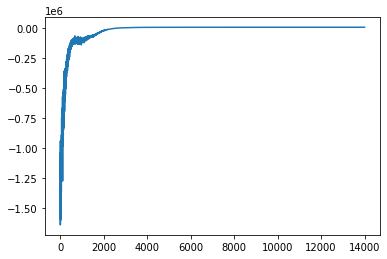

In [4]:
plt.plot(lower_bounds)
#plt.yscale('symlog')